In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 7
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 49 unqiue cards
Generated 1176 cardpairs
-- 294 cardpairs with shared concept
-- 882 cardpairs without shared concept
[(0, 882), (1, 294)]
Total number of matches =  2058
Number of shared concepts per match =  [(1, 2058)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 55566), (0.00048590864917395527, 2058)]

In [5]:
np.sum(count_table)

2058.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 13
xy_div_xyind_rank= 13


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
# figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))
figrange = (0, len(game_data['idx_to_key']), 0, 300)

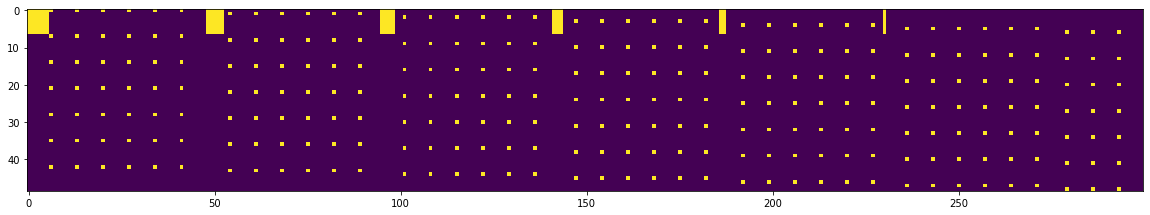

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

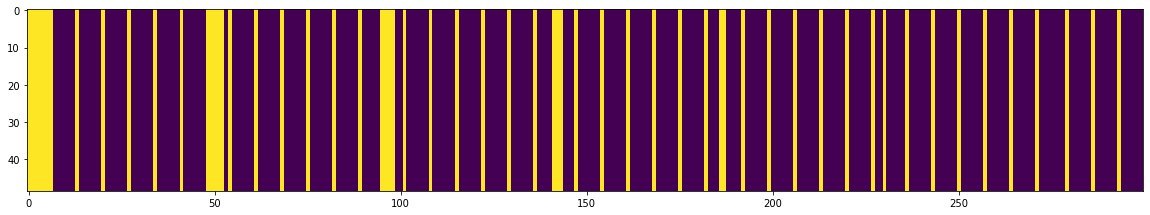

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

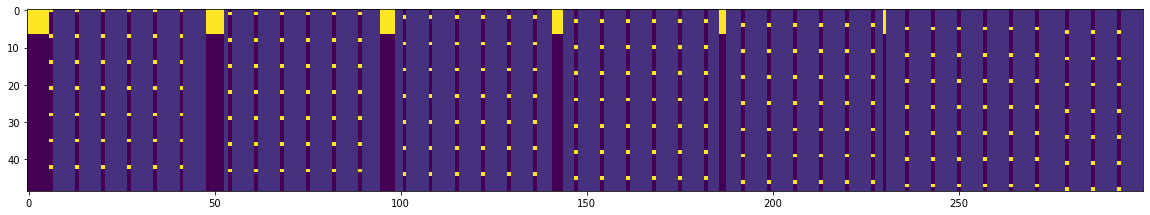

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

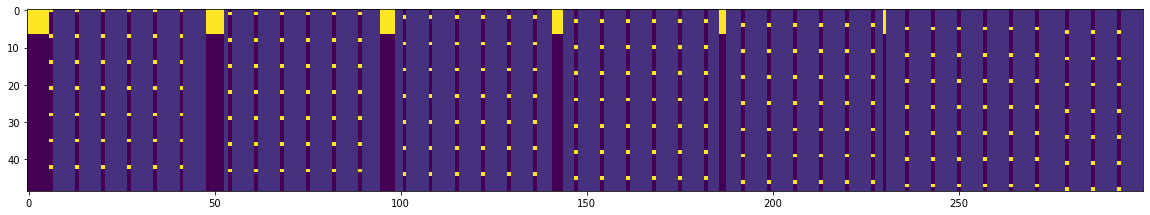

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999988, 31752),
 (1.4406e-96, 12348),
 (0.9999999999999989, 11466),
 (7.0, 2058)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'dotted')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'dashed')
key
 0 ('red', 'void')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'dotted')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'dashed')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [18]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [19]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [20]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [21]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [22]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 4,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K-dotproduct'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 4.9 K 
1  | model.inp_query_layer                        | Sequential         | 4.7 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 4.7 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 4.7 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 196   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 196   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 196   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [ ]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=60000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-23-e10bd6447acb>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 461104 bytes
wandb: WARNING Serializing object of type ndarray that is 461104 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 4.9 K 
1  | model.inp_query_layer                        | Sequential         | 4.7 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 4.7 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 4.7 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 196   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 196   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 196   
8  | loss_criterion                               |

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  9.13it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/

Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|█████     | 1/2 [00:00<00:00,  9.78it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 46:  50%|████

Epoch 74: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 75: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 76: 100%|██████████| 2/2 [00:00<00:00, 14.85it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 77: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s, loss=621, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 78: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s, loss=620, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 79: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s, loss=620, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 80: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s, loss=620, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 81: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s, loss=620, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 82: 100%|██████████| 2/2 [00:00<00:00, 12.88it/s, loss=620, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 83: 100%|████

Epoch 110: 100%|██████████| 2/2 [00:00<00:00, 16.00it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 111: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 112: 100%|██████████| 2/2 [00:00<00:00, 15.28it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 113: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 114: 100%|██████████| 2/2 [00:00<00:00, 11.09it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 115: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 116: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 117: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 118: 100%|██████████| 2/2 [00:00<00:00, 13.21it/s, loss=619, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 119:

Validating: 0it [00:00, ?it/s]
Epoch 148: 100%|██████████| 2/2 [00:00<00:00, 18.54it/s, loss=618, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s, loss=618, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 150: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s, loss=617, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 151: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s, loss=618, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 152:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=617, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 153: 100%|██████████| 2/2 [00:00<00:00, 12.43it/s, loss=617, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 154: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s, loss=617, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 155: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s, loss=617, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 156: 100%|██████████| 2/2 [00:00<00:00, 13.16it/s, loss=617, v_num=6bmz]
Validating

Validating: 0it [00:00, ?it/s]
Epoch 185: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=616, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 186: 100%|██████████| 2/2 [00:00<00:00, 12.22it/s, loss=616, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 187: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s, loss=616, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 188: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=616, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 189: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=616, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 190: 100%|██████████| 2/2 [00:00<00:00, 16.22it/s, loss=616, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 191: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s, loss=616, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 192: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s, loss=615, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 193: 100%|██████████| 2/2 [00:00<00:00, 17.09it/s, loss=615, v_num=6bmz]
Validating

Epoch 222: 100%|██████████| 2/2 [00:00<00:00, 16.25it/s, loss=613, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 223: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s, loss=613, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 224: 100%|██████████| 2/2 [00:00<00:00, 11.46it/s, loss=613, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 225: 100%|██████████| 2/2 [00:00<00:00, 13.71it/s, loss=613, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 226: 100%|██████████| 2/2 [00:00<00:00, 19.51it/s, loss=613, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 227: 100%|██████████| 2/2 [00:00<00:00, 15.48it/s, loss=613, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 228:  50%|█████     | 1/2 [00:00<00:00, 11.80it/s, loss=612, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 229: 100%|██████████| 2/2 [00:00<00:00, 11.60it/s, loss=612, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 230: 100%|██████████| 2/2 [00:00<00:00, 17.13it/s, loss=612, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 231:

Epoch 258: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s, loss=609, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 259: 100%|██████████| 2/2 [00:00<00:00, 10.66it/s, loss=609, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 260: 100%|██████████| 2/2 [00:00<00:00, 15.53it/s, loss=609, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 261: 100%|██████████| 2/2 [00:00<00:00, 15.00it/s, loss=609, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 262: 100%|██████████| 2/2 [00:00<00:00, 15.76it/s, loss=609, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 263: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=609, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 264: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s, loss=608, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 265: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, loss=608, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 266: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s, loss=608, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 267:

Validating: 0it [00:00, ?it/s]
Epoch 295: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s, loss=604, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 296: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s, loss=604, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 297: 100%|██████████| 2/2 [00:00<00:00, 18.70it/s, loss=604, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 298: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s, loss=603, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=603, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 300: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=603, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 301: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s, loss=603, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 302: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=603, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 303: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s, loss=602, v_num=6bmz]
Validating

Epoch 332: 100%|██████████| 2/2 [00:00<00:00, 13.09it/s, loss=598, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 333: 100%|██████████| 2/2 [00:00<00:00, 18.95it/s, loss=598, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 334: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s, loss=598, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 335: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s, loss=598, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 336: 100%|██████████| 2/2 [00:00<00:00, 17.90it/s, loss=598, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 337: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s, loss=597, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 338: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s, loss=597, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 339: 100%|██████████| 2/2 [00:00<00:00, 16.65it/s, loss=597, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 340: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s, loss=597, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 341:

Epoch 369: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=591, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 370: 100%|██████████| 2/2 [00:00<00:00, 12.98it/s, loss=591, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 371: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=591, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 372: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s, loss=590, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 373: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=590, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 374: 100%|██████████| 2/2 [00:00<00:00, 15.60it/s, loss=590, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 375: 100%|██████████| 2/2 [00:00<00:00, 13.34it/s, loss=590, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 376: 100%|██████████| 2/2 [00:00<00:00, 16.28it/s, loss=590, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 377: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s, loss=590, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 378:

Epoch 407: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=583, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 408: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=582, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 409: 100%|██████████| 2/2 [00:00<00:00, 16.91it/s, loss=582, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 410: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s, loss=582, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 411: 100%|██████████| 2/2 [00:00<00:00, 15.01it/s, loss=581, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 412: 100%|██████████| 2/2 [00:00<00:00, 18.35it/s, loss=581, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 413: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s, loss=581, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 414: 100%|██████████| 2/2 [00:00<00:00, 13.34it/s, loss=581, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 415: 100%|██████████| 2/2 [00:00<00:00, 19.77it/s, loss=580, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 416:

Epoch 445: 100%|██████████| 2/2 [00:00<00:00, 19.55it/s, loss=574, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 446: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=574, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 447: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=574, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 448: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s, loss=574, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 449: 100%|██████████| 2/2 [00:00<00:00,  6.16it/s, loss=574, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 450: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s, loss=574, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 451: 100%|██████████| 2/2 [00:00<00:00, 16.97it/s, loss=573, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 452: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=573, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 453: 100%|██████████| 2/2 [00:00<00:00, 15.57it/s, loss=573, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 454:

Epoch 482: 100%|██████████| 2/2 [00:00<00:00, 18.33it/s, loss=565, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 483: 100%|██████████| 2/2 [00:00<00:00, 15.35it/s, loss=565, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 484: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s, loss=564, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 485: 100%|██████████| 2/2 [00:00<00:00, 15.09it/s, loss=565, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 486: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s, loss=564, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 487: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=564, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 488: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=564, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 489: 100%|██████████| 2/2 [00:00<00:00, 10.86it/s, loss=564, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 490: 100%|██████████| 2/2 [00:00<00:00, 18.77it/s, loss=563, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 491:

Epoch 518: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s, loss=557, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 519: 100%|██████████| 2/2 [00:00<00:00, 16.05it/s, loss=557, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 520: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s, loss=556, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 521: 100%|██████████| 2/2 [00:00<00:00, 13.38it/s, loss=557, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 522: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s, loss=556, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 523: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s, loss=556, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 524: 100%|██████████| 2/2 [00:00<00:00, 16.18it/s, loss=556, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 525: 100%|██████████| 2/2 [00:00<00:00, 13.45it/s, loss=556, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 526: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=556, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 527:

Validating: 0it [00:00, ?it/s]
Epoch 555: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s, loss=547, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 556: 100%|██████████| 2/2 [00:00<00:00, 16.24it/s, loss=547, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 557: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s, loss=547, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 558: 100%|██████████| 2/2 [00:00<00:00, 15.07it/s, loss=547, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 559: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s, loss=546, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 560: 100%|██████████| 2/2 [00:00<00:00, 14.55it/s, loss=546, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 561: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=547, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 562: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=546, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 563: 100%|██████████| 2/2 [00:00<00:00, 13.82it/s, loss=546, v_num=6bmz]
Validating

Epoch 591: 100%|██████████| 2/2 [00:00<00:00, 13.05it/s, loss=541, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 592: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s, loss=540, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 593: 100%|██████████| 2/2 [00:00<00:00, 17.21it/s, loss=540, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 594:  50%|█████     | 1/2 [00:00<00:00, 10.42it/s, loss=540, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 595: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s, loss=540, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 596: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=540, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 597:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=540, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 598: 100%|██████████| 2/2 [00:00<00:00, 15.49it/s, loss=539, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 599: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=539, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 600:

Epoch 628: 100%|██████████| 2/2 [00:00<00:00, 16.00it/s, loss=533, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 629: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s, loss=532, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 630: 100%|██████████| 2/2 [00:00<00:00, 15.50it/s, loss=532, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 631: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s, loss=532, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 632: 100%|██████████| 2/2 [00:00<00:00, 18.42it/s, loss=531, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 633: 100%|██████████| 2/2 [00:00<00:00, 15.07it/s, loss=531, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 634: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=532, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 635: 100%|██████████| 2/2 [00:00<00:00, 14.65it/s, loss=531, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 636: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s, loss=531, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 637:

Epoch 665: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=526, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 666: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s, loss=526, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 667: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=526, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 668: 100%|██████████| 2/2 [00:00<00:00, 15.06it/s, loss=526, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 669: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s, loss=525, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 670: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s, loss=525, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 671: 100%|██████████| 2/2 [00:00<00:00, 15.33it/s, loss=525, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 672: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=525, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 673: 100%|██████████| 2/2 [00:00<00:00, 15.90it/s, loss=525, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 674:

Epoch 703: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s, loss=522, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 704:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=522, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 705: 100%|██████████| 2/2 [00:00<00:00, 15.43it/s, loss=522, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 706: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, loss=521, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 707: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s, loss=521, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 708: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s, loss=521, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 709: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=521, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 710: 100%|██████████| 2/2 [00:00<00:00, 18.50it/s, loss=521, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 711: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s, loss=520, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 712:

Epoch 740: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s, loss=517, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 741: 100%|██████████| 2/2 [00:00<00:00, 15.48it/s, loss=517, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 742: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=516, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=516, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 744: 100%|██████████| 2/2 [00:00<00:00, 14.91it/s, loss=516, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 745: 100%|██████████| 2/2 [00:00<00:00, 15.92it/s, loss=516, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 746: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s, loss=515, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 747: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=514, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 748: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s, loss=514, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 749:

Validating: 0it [00:00, ?it/s]
Epoch 777: 100%|██████████| 2/2 [00:00<00:00, 14.46it/s, loss=510, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 778: 100%|██████████| 2/2 [00:00<00:00, 17.01it/s, loss=510, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 779: 100%|██████████| 2/2 [00:00<00:00, 11.50it/s, loss=510, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 780: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s, loss=510, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 781: 100%|██████████| 2/2 [00:00<00:00, 15.99it/s, loss=510, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 782: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s, loss=509, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 783: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s, loss=509, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 784: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s, loss=508, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 785: 100%|██████████| 2/2 [00:00<00:00, 15.50it/s, loss=508, v_num=6bmz]
Validating

Epoch 813: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=506, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 814: 100%|██████████| 2/2 [00:00<00:00, 18.20it/s, loss=506, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 815: 100%|██████████| 2/2 [00:00<00:00, 15.36it/s, loss=506, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 816: 100%|██████████| 2/2 [00:00<00:00, 15.16it/s, loss=505, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 817: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s, loss=505, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 818: 100%|██████████| 2/2 [00:00<00:00, 13.26it/s, loss=505, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 819: 100%|██████████| 2/2 [00:00<00:00, 16.16it/s, loss=506, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 820: 100%|██████████| 2/2 [00:00<00:00, 17.62it/s, loss=505, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 821: 100%|██████████| 2/2 [00:00<00:00, 16.79it/s, loss=505, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 822:

Validating: 0it [00:00, ?it/s]
Epoch 851: 100%|██████████| 2/2 [00:00<00:00, 12.94it/s, loss=502, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 852: 100%|██████████| 2/2 [00:00<00:00, 18.06it/s, loss=503, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 853: 100%|██████████| 2/2 [00:00<00:00, 15.07it/s, loss=503, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 854: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=503, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 855: 100%|██████████| 2/2 [00:00<00:00, 16.16it/s, loss=503, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 856: 100%|██████████| 2/2 [00:00<00:00, 15.47it/s, loss=503, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 857: 100%|██████████| 2/2 [00:00<00:00, 13.10it/s, loss=503, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 858: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s, loss=503, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 859: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s, loss=503, v_num=6bmz]
Validating

Epoch 888: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s, loss=499, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 889: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s, loss=498, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 890: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s, loss=498, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 891: 100%|██████████| 2/2 [00:00<00:00, 15.60it/s, loss=498, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 892: 100%|██████████| 2/2 [00:00<00:00, 17.37it/s, loss=497, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 893:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=497, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 894: 100%|██████████| 2/2 [00:00<00:00, 16.27it/s, loss=497, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 895: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s, loss=498, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 896: 100%|██████████| 2/2 [00:00<00:00, 19.98it/s, loss=498, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 897:

Epoch 925: 100%|██████████| 2/2 [00:00<00:00, 15.30it/s, loss=497, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 926: 100%|██████████| 2/2 [00:00<00:00, 11.51it/s, loss=497, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 927: 100%|██████████| 2/2 [00:00<00:00, 17.81it/s, loss=497, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 928: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s, loss=496, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 929: 100%|██████████| 2/2 [00:00<00:00, 16.48it/s, loss=496, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 930: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s, loss=496, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 931: 100%|██████████| 2/2 [00:00<00:00, 14.64it/s, loss=496, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 932: 100%|██████████| 2/2 [00:00<00:00, 16.13it/s, loss=496, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 933: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s, loss=496, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 934:

Epoch 962: 100%|██████████| 2/2 [00:00<00:00, 16.22it/s, loss=493, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 963: 100%|██████████| 2/2 [00:00<00:00, 16.66it/s, loss=493, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 964: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s, loss=492, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 965: 100%|██████████| 2/2 [00:00<00:00, 18.78it/s, loss=492, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 966: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s, loss=492, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 967: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=492, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 968: 100%|██████████| 2/2 [00:00<00:00, 17.58it/s, loss=491, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 969: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s, loss=491, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 970: 100%|██████████| 2/2 [00:00<00:00, 12.83it/s, loss=491, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 971:

Epoch 1000: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=491, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1001: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=490, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1002: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=491, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1003: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s, loss=490, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1004: 100%|██████████| 2/2 [00:00<00:00, 11.71it/s, loss=490, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1005: 100%|██████████| 2/2 [00:00<00:00, 15.84it/s, loss=490, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1006: 100%|██████████| 2/2 [00:00<00:00, 16.20it/s, loss=490, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1007: 100%|██████████| 2/2 [00:00<00:00, 16.44it/s, loss=490, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1008: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=490, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1038: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s, loss=488, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1039: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s, loss=489, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1040: 100%|██████████| 2/2 [00:00<00:00, 11.06it/s, loss=489, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1041: 100%|██████████| 2/2 [00:00<00:00, 15.54it/s, loss=488, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1042: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s, loss=488, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1043: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1044: 100%|██████████| 2/2 [00:00<00:00, 15.21it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1045: 100%|██████████| 2/2 [00:00<00:00, 19.25it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1046: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1074: 100%|██████████| 2/2 [00:00<00:00, 15.14it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1076: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1077: 100%|██████████| 2/2 [00:00<00:00, 12.83it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1078: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1079: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s, loss=486, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1080: 100%|██████████| 2/2 [00:00<00:00, 18.29it/s, loss=486, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1081: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1082: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s, loss=487, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1111: 100%|██████████| 2/2 [00:00<00:00, 17.50it/s, loss=484, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1112: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s, loss=485, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1113: 100%|██████████| 2/2 [00:00<00:00, 18.04it/s, loss=484, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1114: 100%|██████████| 2/2 [00:00<00:00, 16.42it/s, loss=484, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1115: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s, loss=484, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1116: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s, loss=485, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1117: 100%|██████████| 2/2 [00:00<00:00, 14.67it/s, loss=485, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1118: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s, loss=484, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1119: 100%|██████████| 2/2 [00:00<00:00, 15.70it/s, loss=484, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1148: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1149: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1150: 100%|██████████| 2/2 [00:00<00:00, 17.35it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1151: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1152: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1153: 100%|██████████| 2/2 [00:00<00:00, 15.00it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1154: 100%|██████████| 2/2 [00:00<00:00, 13.04it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1155: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1156: 100%|██████████| 2/2 [00:00<00:00, 16.57it/s, loss=481, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1186: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=479, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1187: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1188: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1189: 100%|██████████| 2/2 [00:00<00:00, 16.79it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1190: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1191: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1192: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1193: 100%|██████████| 2/2 [00:00<00:00, 15.06it/s, loss=479, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1194: 100%|██████████| 2/2 [00:00<00:00, 16.64it/s, loss=480, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1223: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s, loss=480, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1224: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s, loss=479, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1225: 100%|██████████| 2/2 [00:00<00:00, 16.71it/s, loss=479, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1226:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1227: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s, loss=479, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1228: 100%|██████████| 2/2 [00:00<00:00, 13.97it/s, loss=479, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1229: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1230: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1231: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1260: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1261: 100%|██████████| 2/2 [00:00<00:00, 15.79it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1262: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1263: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1264: 100%|██████████| 2/2 [00:00<00:00, 15.47it/s, loss=477, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1265: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s, loss=477, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1266: 100%|██████████| 2/2 [00:00<00:00, 15.80it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1267: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1268: 100%|██████████| 2/2 [00:00<00:00, 14.65it/s, loss=478, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1297: 100%|██████████| 2/2 [00:00<00:00, 15.58it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1298: 100%|██████████| 2/2 [00:00<00:00, 13.54it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1299: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1300: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1301: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s, loss=475, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1302: 100%|██████████| 2/2 [00:00<00:00, 12.87it/s, loss=475, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1303: 100%|██████████| 2/2 [00:00<00:00, 16.98it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1304: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s, loss=475, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1305: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=475, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1333: 100%|██████████| 2/2 [00:00<00:00, 17.96it/s, loss=475, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1334: 100%|██████████| 2/2 [00:00<00:00, 15.24it/s, loss=475, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1335: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=475, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1336: 100%|██████████| 2/2 [00:00<00:00, 17.29it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1337: 100%|██████████| 2/2 [00:00<00:00, 15.01it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1338: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1339: 100%|██████████| 2/2 [00:00<00:00, 19.06it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1340: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1341: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s, loss=476, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1371: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1372: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1373: 100%|██████████| 2/2 [00:00<00:00, 16.80it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1374: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1375: 100%|██████████| 2/2 [00:00<00:00, 16.23it/s, loss=472, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1376: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1377: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1378: 100%|██████████| 2/2 [00:00<00:00, 13.24it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1379: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s, loss=473, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1407: 100%|██████████| 2/2 [00:00<00:00, 12.44it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1408: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1409:  50%|█████     | 1/2 [00:00<00:00, 10.39it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1410: 100%|██████████| 2/2 [00:00<00:00, 10.84it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1411: 100%|██████████| 2/2 [00:00<00:00, 12.32it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1412: 100%|██████████| 2/2 [00:00<00:00, 17.48it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1413: 100%|██████████| 2/2 [00:00<00:00, 16.91it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1414: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1415: 100%|██████████| 2/2 [00:00<00:00, 15.92it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1444: 100%|██████████| 2/2 [00:00<00:00, 13.75it/s, loss=470, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1445: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=470, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1446: 100%|██████████| 2/2 [00:00<00:00, 14.62it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1447: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1448: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1449: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1450: 100%|██████████| 2/2 [00:00<00:00, 15.37it/s, loss=470, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1451: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1452: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s, loss=471, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1479: 100%|██████████| 2/2 [00:00<00:00, 15.92it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1480:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1481: 100%|██████████| 2/2 [00:00<00:00, 16.15it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1482: 100%|██████████| 2/2 [00:00<00:00, 17.65it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1483: 100%|██████████| 2/2 [00:00<00:00, 13.80it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1484: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1485: 100%|██████████| 2/2 [00:00<00:00, 17.83it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1486: 100%|██████████| 2/2 [00:00<00:00, 16.98it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1487: 100%|██████████| 2/2 [00:00<00:00, 13.00it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1517: 100%|██████████| 2/2 [00:00<00:00, 12.95it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1518: 100%|██████████| 2/2 [00:00<00:00, 16.19it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1519: 100%|██████████| 2/2 [00:00<00:00, 15.21it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1520: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1521: 100%|██████████| 2/2 [00:00<00:00, 19.46it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1522: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1523: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1524: 100%|██████████| 2/2 [00:00<00:00, 16.47it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1525: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s, loss=467, v_num=6bmz]
V

Epoch 1553: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1554: 100%|██████████| 2/2 [00:00<00:00, 16.58it/s, loss=468, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1555: 100%|██████████| 2/2 [00:00<00:00, 16.12it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1556: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1557:  50%|█████     | 1/2 [00:00<00:00, 11.87it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1558: 100%|██████████| 2/2 [00:00<00:00, 13.00it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1559: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1560: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1561: 100%|██████████| 2/2 [00:00<00:00, 17.52it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1590: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1591: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1592: 100%|██████████| 2/2 [00:00<00:00, 14.85it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1593:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1594: 100%|██████████| 2/2 [00:00<00:00, 18.10it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1595: 100%|██████████| 2/2 [00:00<00:00, 15.00it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1596: 100%|██████████| 2/2 [00:00<00:00, 12.57it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1597: 100%|██████████| 2/2 [00:00<00:00, 11.88it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1598: 100%|██████████| 2/2 [00:00<00:00, 13.04it/s, loss=466, v_num=6bmz]
V

Validating: 0it [00:00, ?it/s]
Epoch 1627: 100%|██████████| 2/2 [00:00<00:00, 18.79it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1628: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=467, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1629: 100%|██████████| 2/2 [00:00<00:00, 16.42it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1630: 100%|██████████| 2/2 [00:00<00:00, 17.59it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1631: 100%|██████████| 2/2 [00:00<00:00, 15.58it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1632: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1633: 100%|██████████| 2/2 [00:00<00:00, 18.28it/s, loss=465, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1634: 100%|██████████| 2/2 [00:00<00:00, 15.38it/s, loss=465, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1635: 100%|██████████| 2/2 [00:00<00:00, 12.73it/s, loss=465, v_num=6bmz]
V

Epoch 1663: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=465, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1664: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s, loss=466, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1665: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s, loss=465, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1666: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1667: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1668: 100%|██████████| 2/2 [00:00<00:00, 18.49it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1669: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1670: 100%|██████████| 2/2 [00:00<00:00, 15.61it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1671: 100%|██████████| 2/2 [00:00<00:00, 15.81it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1700: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s, loss=462, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1701: 100%|██████████| 2/2 [00:00<00:00, 11.57it/s, loss=462, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1702: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1703: 100%|██████████| 2/2 [00:00<00:00, 12.98it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1704: 100%|██████████| 2/2 [00:00<00:00, 15.75it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1705: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1706: 100%|██████████| 2/2 [00:00<00:00, 15.70it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1707: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s, loss=465, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1708: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s, loss=465, v_num=6bmz]
V

Epoch 1737: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s, loss=462, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1738: 100%|██████████| 2/2 [00:00<00:00, 15.37it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1739: 100%|██████████| 2/2 [00:00<00:00, 12.35it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1740: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1741: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1742: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1743: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1744: 100%|██████████| 2/2 [00:00<00:00, 15.92it/s, loss=463, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1745: 100%|██████████| 2/2 [00:00<00:00, 16.40it/s, loss=464, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1774: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1775: 100%|██████████| 2/2 [00:00<00:00, 13.39it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1776: 100%|██████████| 2/2 [00:00<00:00, 16.62it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1777: 100%|██████████| 2/2 [00:00<00:00, 16.06it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1778: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1779: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1780: 100%|██████████| 2/2 [00:00<00:00, 14.99it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1781: 100%|██████████| 2/2 [00:00<00:00, 16.21it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1782: 100%|██████████| 2/2 [00:00<00:00, 19.07it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1810: 100%|██████████| 2/2 [00:00<00:00, 17.73it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1811: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1812: 100%|██████████| 2/2 [00:00<00:00, 17.56it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1813: 100%|██████████| 2/2 [00:00<00:00, 15.49it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1814: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1815: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1816: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1817: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1818: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s, loss=459, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1847: 100%|██████████| 2/2 [00:00<00:00, 16.87it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1848: 100%|██████████| 2/2 [00:00<00:00, 15.49it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1849: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1850: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1851: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1852: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1853: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1854: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1855: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1882: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1883: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1884: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1885: 100%|██████████| 2/2 [00:00<00:00, 16.41it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1886: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1887: 100%|██████████| 2/2 [00:00<00:00, 11.99it/s, loss=460, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1888: 100%|██████████| 2/2 [00:00<00:00, 16.32it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1889: 100%|██████████| 2/2 [00:00<00:00, 15.48it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1890: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=461, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1919: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1920: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1921: 100%|██████████| 2/2 [00:00<00:00, 15.85it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1922: 100%|██████████| 2/2 [00:00<00:00, 15.07it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1923: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1924: 100%|██████████| 2/2 [00:00<00:00, 13.54it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1925: 100%|██████████| 2/2 [00:00<00:00, 14.88it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1926:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1927: 100%|██████████| 2/2 [00:00<00:00, 17.10it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1957: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s, loss=458, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1958: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1959: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1960: 100%|██████████| 2/2 [00:00<00:00, 17.16it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1961: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1962: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1963: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1964: 100%|██████████| 2/2 [00:00<00:00, 17.14it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1965: 100%|██████████| 2/2 [00:00<00:00, 14.79it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 1993: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1994: 100%|██████████| 2/2 [00:00<00:00, 16.08it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1996: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1997: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1998: 100%|██████████| 2/2 [00:00<00:00, 16.31it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2000: 100%|██████████| 2/2 [00:00<00:00, 16.03it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2001: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2029: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2030: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2031: 100%|██████████| 2/2 [00:00<00:00, 16.68it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2032: 100%|██████████| 2/2 [00:00<00:00, 18.84it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2033: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2034: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2035: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2036: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2037: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2066: 100%|██████████| 2/2 [00:00<00:00, 15.69it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2067: 100%|██████████| 2/2 [00:00<00:00, 17.37it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2068: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s, loss=457, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2069: 100%|██████████| 2/2 [00:00<00:00, 16.51it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2070:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2071:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2072: 100%|██████████| 2/2 [00:00<00:00, 16.40it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2073: 100%|██████████| 2/2 [00:00<00:00, 15.53it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2074: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2103: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s, loss=456, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2104: 100%|██████████| 2/2 [00:00<00:00, 14.57it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2105: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2106: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2107: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2108: 100%|██████████| 2/2 [00:00<00:00, 13.90it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2109: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2110: 100%|██████████| 2/2 [00:00<00:00, 18.38it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2111: 100%|██████████| 2/2 [00:00<00:00, 15.98it/s, loss=456, v_num=6bmz]
V

Epoch 2138: 100%|██████████| 2/2 [00:00<00:00, 19.74it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2139: 100%|██████████| 2/2 [00:00<00:00, 10.94it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2140: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2141: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2142: 100%|██████████| 2/2 [00:00<00:00, 15.61it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2143: 100%|██████████| 2/2 [00:00<00:00, 15.56it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2144: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2145: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2146: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=455, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2173: 100%|██████████| 2/2 [00:00<00:00, 17.76it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2174: 100%|██████████| 2/2 [00:00<00:00, 11.13it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2175: 100%|██████████| 2/2 [00:00<00:00, 17.33it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2176: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2177: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2178: 100%|██████████| 2/2 [00:00<00:00, 12.50it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2179: 100%|██████████| 2/2 [00:00<00:00, 15.85it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2180:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2181: 100%|██████████| 2/2 [00:00<00:00, 11.47it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2210: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2211: 100%|██████████| 2/2 [00:00<00:00, 16.80it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2212: 100%|██████████| 2/2 [00:00<00:00, 13.73it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2213: 100%|██████████| 2/2 [00:00<00:00, 15.55it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2214: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s, loss=451, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2215: 100%|██████████| 2/2 [00:00<00:00, 13.12it/s, loss=451, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2216: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2217: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2218: 100%|██████████| 2/2 [00:00<00:00, 16.24it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2248: 100%|██████████| 2/2 [00:00<00:00, 15.45it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2249: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2250: 100%|██████████| 2/2 [00:00<00:00, 15.27it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2251: 100%|██████████| 2/2 [00:00<00:00, 15.30it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2252: 100%|██████████| 2/2 [00:00<00:00, 15.27it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2253:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2254:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2255: 100%|██████████| 2/2 [00:00<00:00, 16.48it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2256: 100%|██████████| 2/2 [00:00<00:00, 11.01it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2285: 100%|██████████| 2/2 [00:00<00:00, 11.85it/s, loss=454, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2286: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2287: 100%|██████████| 2/2 [00:00<00:00, 19.82it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2288: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2289: 100%|██████████| 2/2 [00:00<00:00, 16.18it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2290: 100%|██████████| 2/2 [00:00<00:00, 18.52it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2291: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2292: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2293: 100%|██████████| 2/2 [00:00<00:00, 15.43it/s, loss=453, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2322: 100%|██████████| 2/2 [00:00<00:00, 14.90it/s, loss=451, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2323: 100%|██████████| 2/2 [00:00<00:00, 16.91it/s, loss=451, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2324: 100%|██████████| 2/2 [00:00<00:00, 15.18it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2325: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2326: 100%|██████████| 2/2 [00:00<00:00, 16.78it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2327: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s, loss=451, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2328: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2329: 100%|██████████| 2/2 [00:00<00:00, 16.21it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2330: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s, loss=452, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2358: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2359: 100%|██████████| 2/2 [00:00<00:00, 12.65it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2360: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2361: 100%|██████████| 2/2 [00:00<00:00, 15.30it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2362: 100%|██████████| 2/2 [00:00<00:00, 15.70it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2363: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2364: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2365: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2366: 100%|██████████| 2/2 [00:00<00:00, 15.73it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2396: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2397: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2398: 100%|██████████| 2/2 [00:00<00:00, 19.83it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2399: 100%|██████████| 2/2 [00:00<00:00,  7.26it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2400: 100%|██████████| 2/2 [00:00<00:00, 17.64it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2401: 100%|██████████| 2/2 [00:00<00:00, 11.10it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2402: 100%|██████████| 2/2 [00:00<00:00, 15.70it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2403: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2404: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2432: 100%|██████████| 2/2 [00:00<00:00, 13.17it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2433: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s, loss=451, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2434: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2435: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2436: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2437: 100%|██████████| 2/2 [00:00<00:00, 15.53it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2438: 100%|██████████| 2/2 [00:00<00:00, 16.32it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2439: 100%|██████████| 2/2 [00:00<00:00, 13.26it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2440: 100%|██████████| 2/2 [00:00<00:00, 16.03it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2468: 100%|██████████| 2/2 [00:00<00:00, 18.13it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2469: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2470:  50%|█████     | 1/2 [00:00<00:00, 10.44it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2471: 100%|██████████| 2/2 [00:00<00:00, 11.66it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2472: 100%|██████████| 2/2 [00:00<00:00, 11.28it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2473: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2474: 100%|██████████| 2/2 [00:00<00:00, 19.52it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2475: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2476: 100%|██████████| 2/2 [00:00<00:00, 15.85it/s, loss=448, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
E

Epoch 2503: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2504: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s, loss=450, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2505: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2506:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2507: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=449, v_num=6bmz]
Validating: 0it [00:00, ?it/s]
Epoch 2507: 100%|██████████| 2/2 [00:00<00:00,  7.34it/s, loss=449, v_num=6bmz]
                                                         

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '2iwcafn1') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=800, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '2iwcafn1') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])